# Notæ 9


## Herramientas computacionales para asistir al estudio analítico de problemas

Este notebook tiene por objetivo brindar herramientas computacionales para asistir al estudio analítico de problemas: abordaje de conjeturas, búsqueda de contraejemplos, e inferencia de propiedades sobre la estructura de las soluciones para la posterior postulación de conjeturas o demostración de teoremas.

También aprenderemos a trabajar con grandes datasets, constituidos por *todos* los grafos de hasta cierto número de vértices, también clasificados por clases de grafos. Estos dataset se encuentran ya generados y subidos a la web, lo que permite realizar inspecciones exhaustivas (por fuerza bruta) de propiedades/conjeturas sobre todos los grafos pequeños.

## 1. Descargando los datasets

En el Notebook 5, aprendimos a generar datasets usando generadores para diferentes clases de grafos, como por ejemplo, grafos generales aleatorios, bipartitos aleatorios, split aleatorios, webs, etc...

En este Notebook, vamos a seguir un enfoque diferente. Vamos a descargar datasets de la siguiente página web:

<a href="https://users.cecs.anu.edu.au/~bdm/data/graphs.html"> https://users.cecs.anu.edu.au/~bdm/data/graphs.html </a>

Esta página, tiene generados exhaustivamente todos los grafos posibles con hasta cierto número de vértices (salvo isomorfismo). A su vez, también los tiene filtrados según ciertas clases de grafos: conexos, cordales, perfectos, planares, auto-complementarios, etc...

Por ejemplo, todos los grafos conexos de 4 vértices se enumeran en el siguiente link:

<a href="https://users.cecs.anu.edu.au/~bdm/data/graph4c.g6"> https://users.cecs.anu.edu.au/~bdm/data/graph4c.g6</a>

Podemos ingresar al link y guardar su contenido manualmente. Pero... ya que estamos usando Python, aprovechemos su flexibilidad para automatizar este proceso. Usaremos el módulo <code>requests</code> de Python para recuperar el contenido de una página web (obviamente necesitará conexión a Internet para ejecutar la siguiente celda).

In [17]:
import requests

f = requests.get("https://users.cecs.anu.edu.au/~bdm/data/graph4c.g6")
print(f.text)

CF
CU
CV
C]
C^
C~



Este formato contiene una linea por cada posible grafo y cada línea codifica un grafo en formato graph6. En total hay 6 grafos conexos no isomorfos de 4 vértices. Para otros números de vértices, sugerimos consultar la secuencia <a href="https://oeis.org/A001349"> A001349</a> para conocer el número de grafos conexos no isomorfos (tener en cuenta que la secuencia comienza desde 0 vértices). 

Intentemos construir el grafo asociado a cada codificación, mediante el paquete <code>NetworkX</code>. Para ejemplificar, usaremos la primer linea.

In [18]:
grafo_codificado = f.text.split()[0]
print(grafo_codificado)

CF


Vamos a utilizar la función <code>from_graph6_bytes</code> de <code>NetworkX</code>, la cual toma una cadena de texto codificada en formato graph6 y la convierte en un grafo. En este punto hay que hacer una aclaración, esta función, en lugar de una string, toma bytes. Por el momento, no nos preocupemos por entender qué son los bytes o para qué se usan. Para solucionar esto, necesitamos un paso intermedio donde convertimos la string a bytes.

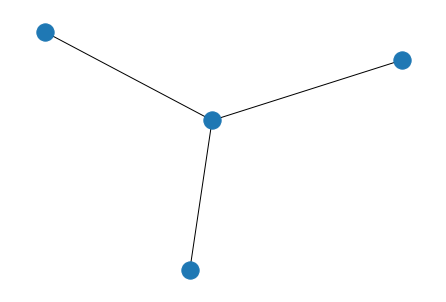

In [19]:
import networkx as nx

grafo_codificado_bytes = bytes(grafo_codificado, "utf-8")
grafo = nx.from_graph6_bytes(grafo_codificado_bytes)
nx.draw(grafo)

Ok, ahora que ya entendemos el transfondo de lo que vamos a hacer, podemos empezar a contruir nuestro dataset. Primero vamos a descargar a nuestra máquina todos los grafos conexos con 2, 3, 4, 5, 6, 7, 8, 9, y 10 vértices.

Podemos hacer esto de forma manual, es decir, por ejemplo, para descargar el dataset de grafos conexos de 2 vértices, primero ingresamos a <a href="https://users.cecs.anu.edu.au/~bdm/data/graph2c.g6"> https://users.cecs.anu.edu.au/~bdm/data/graph2c.g6</a>, y luego apretamos el click derecho y elegimos "Guardar como...".

Sin embargo, es más rápido (y divertido) automatizarlo con Python. Veamos cómo hacer esto. Primero creamos un directorio de trabajo donde vamos a guardar nuestros datasets. El directorio se llamará "dataset-n9". Usamos el argumento <code>exist_ok=True</code> para evitar que Python lance una excepción si el directorio ya existía (por ejemplo, si volvemos a ejecutar la celda).

In [20]:
import os

dirName = "dataset-n9"
os.makedirs(dirName, exist_ok=True)

Ahora vamos a descargar los datasets. Primero especificamos la url y creamos una lista con los datasets que queremos descargar. Por el momento, ignoremos el dataset con los grafos conexos de 10 vértices.

In [21]:
url = "https://users.cecs.anu.edu.au/~bdm/data/"
datasets = [f"graph{n}c.g6" for n in [2,3,4,5,6,7,8,9]]

print(url)
print(datasets)

https://users.cecs.anu.edu.au/~bdm/data/
['graph2c.g6', 'graph3c.g6', 'graph4c.g6', 'graph5c.g6', 'graph6c.g6', 'graph7c.g6', 'graph8c.g6', 'graph9c.g6']


Ahora, descargamos el texto que codifica a cada dataset y lo escribimos en un archivo local con el mismo nombre, dentro del directorio <code>dirName</code>.

In [ ]:
for dataset in datasets:
    respuesta = requests.get(url + dataset)
    with open(dirName + "/" + dataset, "w") as file:
        file.write(respuesta.text)

¡Listo! Para verificar, podemos listar el directorio para verificar que los archivos se hayan creado. También podemos mostremos el contenido de alguno de ellos.

In [17]:
os.listdir(dirName)

['graph6c.g6',
 'graph5c.g6',
 'graph9c.g6',
 'graph10c.g6',
 'graph3c.g6',
 'graph10c.g6.gz',
 'graph7c.g6',
 'graph8c.g6',
 'graph4c.g6',
 'graph2c.g6']

In [19]:
with open(dirName + "/" + "graph4c.g6", "r") as file:
    print(file.read())

CF
CU
CV
C]
C^
C~



Volvamos ahora al dataset con los grafos conexos de 10 vértices. El inconveniente con él, es que se encuentra comprimido como un archivo *gzip*. Con algunos pasos extras, es posible manejarlo. Al igual que antes, comenzamos por descargar el texto que codifica el dataset y lo escribimos en un archivo local, con dos diferencias:
* El archivo estará comprimido como un archivo *gzip*, por eso su extensión ".gz".
* En lugar de escribir el texto como una cadena de caracteres (string), lo escribiremos como una cadena de bytes. Por el momento no vamos a profundizar en este tema, sólo mencionar que es necesario para poder descomprimirlo. Por este motivo, el modo de apertura del archivo es "wb" y escribimos el atributo <code>content</code> en lugar de <code>text</code>.

**Nota.** El archivo pesa 30 MB, por lo que la ejecución de la siguiente celda puede demorar dependiendo de la velocidad de conexión.

In [15]:
respuesta = requests.get("https://users.cecs.anu.edu.au/~bdm/data/graph10c.g6.gz")
with open(dirName + "/graph10c.g6.gz", "wb") as file:
    file.write(respuesta.content)

Ahora si, ya estamos en condiciones de descomprimirlo. Abrimos el archivo con la función <code>open</code> del paquete <code>gzip</code>, la cual se ocupa de leer y descomprimir, y escribimos el resultado en un archivo local, con el mismo nombre pero sin la extensión ".g6".

In [16]:
import gzip

with gzip.open(dirName + "/graph10c.g6.gz", "rb") as fEntrada:
    with open(dirName + "/graph10c.g6", "wb") as fSalida:
        fSalida.write(fEntrada.read())

Imprimamos las primeras 5 líneas del archivo para verificar que salió todo ok.

In [21]:
with open(dirName + "/" + "graph10c.g6", "r") as file:
    for _ in range(5):
        print(next(file))

I??????~w

I????A?~o

I????A?~w

I????B?Nw

I????B?no



## 2. Conteo exhaustivo de grafos

Empezemos por mostrar como utilizar el dataset para contar el número de grafos conexos con cierta propiedad de interés, por ejemplo que carezcan de mellizos verdaderos.

**Definición.** Dado un grafo $G = (V,E)$, dos vértices distintos $u,v \in V$ son **mellizos verdaderos** si tienen la misma vecindad cerrada, es decir, $N[u] = N[v]$. 

**Observación.** Para que dos vértices sean mellizos verdaderos, es necesario que sean adyacentes.

Por ejemplo, considerar el siguiente grafo:

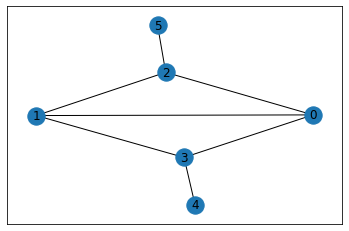

In [22]:
grafo = nx.Graph()
grafo.add_edges_from([(0,1), (0,2), (0,3), (1,2), (1,3), (3,4), (2,5)])
nx.draw_networkx(grafo)

Los vértices $0$ y $1$ son mellizos verdaderos pues: $$N[0] = N[1] = \{0,1,2,3\}.$$ Por el contrario, los vértices $0$ y $2$ no lo son, pues $$N[0] = \{0,1,2,3\} \neq \{0,1,2,5\} = N[2].$$

Supongamos que queremos determinar *cuántos grafos conexos con a lo sumo 9 vértices no tienen ningún par de mellizos verdaderos*.

Empecemos definiendo una función que determine si dos vértices son mellizos verdaderos.

In [23]:
def son_mellizos_verdaderos(G,u,v):
    if not G.has_edge(u,v):
        return False
    Nu = set(G.neighbors(u))
    Nu.add(u)
    Nv = set(G.neighbors(v))
    Nv.add(v)
    return (Nu == Nv)
    
assert son_mellizos_verdaderos(grafo, 0, 1)
assert not son_mellizos_verdaderos(grafo, 0, 2)

Usemos <code>son_mellizos_verdaderos</code> para definir el predicado (función que retorna un valor booloeano)<code>no_tiene_mellizos_verdaderos</code> que determina si un grafo no tiene ningún par de mellizos verdaderos.

In [24]:
def no_tiene_mellizos_verdaderos(G):
    for u,v in G.edges:
        if son_mellizos_verdaderos(G, u, v):
            return False
    return True

assert not no_tiene_mellizos_verdaderos(grafo)
grafo2 = nx.Graph(grafo)
grafo2.add_edge(1,5)
assert no_tiene_mellizos_verdaderos(grafo2)

Ahora tenemos que recorrer todos los datasets y contar cuántas instancias verifican el predicado <code>no_tiene_mellizos_verdaderos</code>. Vamos a escribir una función más general, que permita ser llamada con diferentes predicados. Vamos a definir una función <code>contar_grafos</code>, que toma la ruta del directorio que contiene los datasets, una lista con los nombres de los datasets involucrados en el experimento y un predicado, y se ocupa de contar cuántas instancias de los datasets verifican el predicado dado. En su definición, vale la pena mencionar que abrimos nuevamente cada dataset en modo "rb", es decir, como bytes. A cada línea del archivo del dataset, es necesario sacarle el último caracter que representa un salto de línea (\n), esto se hace con el método <code>rstrip(b"\n")</code> (se antepone una *b* a la string "\n" para convertirla en bytes).

In [25]:
def contar_grafos(dirName, datasets, predicado):
    contador = 0
    for dataset in datasets:
        print("Procesando dataset:", dataset)
        with open(dirName + "/" + dataset, "rb") as file:
            # Recorrer cada linea del archivo
            for line in file:
                # Remover el salto de linea (\n)
                line = line.rstrip(b"\n")
                # Leer grafo en formato graph6
                grafo = nx.from_graph6_bytes(line)
                if predicado(grafo):
                    contador += 1
    return contador

Finalmente, llamamos a nuestra función.

In [28]:
datasets = [f"graph{n}c.g6" for n in [2,3,4,5,6,7,8,9]]
contar_grafos(dirName, datasets, no_tiene_mellizos_verdaderos)

Procesando dataset: graph2c.g6
Procesando dataset: graph3c.g6
Procesando dataset: graph4c.g6
Procesando dataset: graph5c.g6
Procesando dataset: graph6c.g6
Procesando dataset: graph7c.g6
Procesando dataset: graph8c.g6
Procesando dataset: graph9c.g6


205797

### &#x1f4bb; Actividad 1

* ¿Cúantos grafos conexos con a lo sumo 9 vértices son regulares? ¿Qué porcentaje representa este número sobre el total?
* ¿Y con a lo sumo 10 vértices? **Nota:** esto puede llevar mucho tiempo (son casi 12M de grafos)

In [ ]:
# Espacio para completar actividad 1

## 2. Búsqueda exhaustiva de contraejemplos

En esta sección vamos a seguir como caso de estudio el problema de Empaquetamiento Generalizado. Empecemos con algunas definiciones.

**Definiciones.** Dado un grafo $G=(V,E)$ y dos vectores $\mathbf{k}, \textbf{u} \in \mathbb Z_+^V$, $f:V\rightarrow \mathbb Z_+$ es una función de $(\mathbf{k}, \textbf{u})$-empaquetamiento si para todo $v\in V$ se verifica $f(v)\leq u(v)$ y $f(N[v])\leq k(v)$. El problema de Empaquetamiento Generalizado consiste en calcular:

$$ L_{\mathbf{k}, \textbf{u}}(G)=\max \{f(V): f \text{ una función de } (\mathbf{k}, \textbf{u})\text{-empaquetamiento de } G\},$$

donde $f(V) \doteq \sum_{v \in V}f(v)$.

Se puede probar que resolver el problema denominado <a href="https://doi.org/10.1016/j.disc.2007.08.080">*Signed Domination*</a> sobre un grafo $G=(V,E)$ es equivalente, desde el punto de vista de su complejidad computacional, a calcular $L_{\mathbf{k}, \textbf{u}}(G)$ con $k(v)=\delta(v)$, donde $\delta(v)$ es el grado de $v$, y $u(v)=2$, para todo $v\in V$.

Claramente, si toda funcion de $(\mathbf{k}, \textbf{u})$-empaquetamiento de $G$ debe verificar $f(N[v])\leq \delta(v)$ necesariamente para todo $v$, $f(w)=0$ para algun $w\in N[v]$. O sea, el conjunto de vértices $\mathcal N$ donde $f$ es nula debe ser un conjunto dominante, esto es, $\mathcal N \cap N[v]\neq \emptyset$, para todo $v$. 

Entonces, una función que vale cero en un conjunto dominante mínimo de $G$ y uno en el resto es una funcion de $(\mathbf{k}, \textbf{u})$-empaquetamiento de $G$ de valor $n-\gamma(G)$, donde $n$ es el número de vértices de $G$ y $\gamma(G)$ su número de dominación.

Por otro lado, si subimos al valor 2 el valor de la función propuesta sobre un vértice, deberemos bajar de 1 a 0 el valor de al menos un vertice en las vecindades de todos sus vecinos. 

Estas dos observaciones nos llevan a pensar si la solución propuesta no será la solución óptima. Esto es, si será cierto o no que:
$$L_{\mathbf{k}, \textbf{u}}(G)=n-\gamma(G).$$

### &#x1f4bb; Actividad 2

* Proponer formulaciones de PLE que calculen $\delta(G)$ y $L_{\mathbf{k}, \textbf{u}}(G)$.
* Definir funciones <code>construir_modelo_dom</code> y <code>construir_modelo_gemp</code> que construyan un modelo en Python basado en las formulaciones anteriores.
* Haciendo uso de las funciones anteriores, definir una función <code>conjetura_ej2</code> que tome un grafo $G$ y determine si vale o no: $$L_{\mathbf{k}, \textbf{u}}(G)=n-\gamma(G),$$ es decir, que devuelva <code>True</code> o <code>False</code>. Recordar que usaremos como $\mathbf{k}$ al vector de grados y como $\textbf{u}$ al vector con todas sus componentes igual a 2.
* Encontrar un contraejemplo para la conjetura en grafos conexos de a lo sumo 10 vértices. **Recomendación:** modificar la función <code>buscar_contrajemplo</code>, para que, en lugar de contar los grafos que verifiquen el predicado, retorne el primer grafo que no lo cumpla. Imprima el grafo retornado y sus soluciones óptimas para ambos modelos.
* Si el primer contraejemplo tiene $p$ nodos, buscar para cada $r\in [p+1,10]$ un contraejemplo con $r$ nodos, si existe. 
* Analizar las soluciones óptimas encontradas en estos ejemplos y tratar de concluir alguna propiedad no tenida en cuanta al momento de establecer la conjetura e investigar qué la hace fallar. 

In [67]:
# Espacio para completar actividad 2

**Acá abajo está mi resolución.**

In [43]:
from docplex.mp.model import Model

In [44]:
def construir_modelo_dom(G):
    modelo = Model(name='dom')
    X = [modelo.binary_var(name='x_' + str(v)) for v in G]
    modelo.minimize(modelo.sum(X[v] for v in G))
    for v in G:
        modelo.add_constraint(X[v] + modelo.sum(X[u] for u in G.neighbors(v)) >= 1)  
    return modelo

In [45]:
def construir_modelo_gemp(G, k, u):
    modelo = Model(name='gemp')
    F = [modelo.integer_var(0, u[v], name='f_' + str(v)) for v in G]
    modelo.maximize(modelo.sum(F[v] for v in G))
    for v in G:
        modelo.add_constraint(F[v] + modelo.sum(F[u] for u in G.neighbors(v)) <= k[v])  
    return modelo

In [54]:
def conjetura_ej2(G):
    n = G.number_of_nodes()
    model_dom = construir_modelo_dom(G)
    model_gemp = construir_modelo_gemp(G, [G.degree(v) for v in G], [2] * n)
    model_dom.solve()
    model_gemp.solve()
    return model_gemp.objective_value == n - model_dom.objective_value

In [55]:
def buscar_contraejemplo(dirName, datasets, predicado):
    for dataset in datasets:
        print("Procesando dataset:", dataset)
        with open(dirName + "/" + dataset, "rb") as file:
            # Recorrer cada linea del archivo
            for line in file:
                # Remover el salto de linea (\n)
                line = line.rstrip(b"\n")
                # Leer grafo en formato graph6
                grafo = nx.from_graph6_bytes(line)
                if not predicado(grafo):
                    return grafo
    return None

Procesando dataset: graph2c.g6
Procesando dataset: graph3c.g6
Procesando dataset: graph4c.g6
Procesando dataset: graph5c.g6


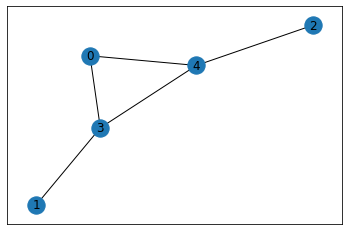

In [57]:
datasets = [f"graph{n}c.g6" for n in [2,3,4,5,6,7,8,9]]
contraej = buscar_contraejemplo(dirName, datasets, conjetura_ej2)
nx.draw_networkx(contraej)

In [60]:
model_dom = construir_modelo_dom(contraej)
sol = model_dom.solve()
sol.display()

solution for: dom
objective: 2
status: OPTIMAL_SOLUTION(2)
x_3 = 1
x_4 = 1


In [63]:
model_gemp = construir_modelo_gemp(contraej, 
                                   [contraej.degree(v) for v in contraej], 
                                   [2] * contraej.number_of_nodes())
sol = model_gemp.solve()
sol.display()

solution for: gemp
objective: 4
status: OPTIMAL_SOLUTION(2)
f_0 = 2
f_1 = 1
f_2 = 1


In [66]:
for i in [6,7,8,9,10]:
    datasets = [f"graph{i}c.g6"]
    contraej = buscar_contraejemplo(dirName, datasets, conjetura_ej2)
    print(contraej)

Procesando dataset: graph6c.g6
Graph with 6 nodes and 6 edges
Procesando dataset: graph7c.g6
Graph with 7 nodes and 7 edges
Procesando dataset: graph8c.g6
Graph with 8 nodes and 8 edges
Procesando dataset: graph9c.g6
Graph with 9 nodes and 9 edges
Procesando dataset: graph10c.g6
Graph with 10 nodes and 10 edges


## 3. Limitaciones de la búsqueda exhaustiva

En esta sección vamos a seguir como caso de estudio el ya conocido problema de Coloreo de Grafo. En particular, vamos a trabajar sobre el teorema de los 4 colores. Empecemos repasando algunas definiciones.

**Definición.** Un grafo es planar si se puede embeber en el plano (usando puntos para los vértices y curvas para las aristas) sin que las aristas se crucen.

**Teorema de los 4 colores.** Dado un grafo planar $G$, $\chi(G) \leq 4$ (recordar que $\chi(G)$ es el número cromático de $G$, es decir, la mínima cantidad de colores necesarios para colorear a $G$).

¿Será posible ajustar un poco más la cota del teorema de los 4 colores? Es decir, ¿será cierto que todo grafo planar es 3-coloreable? **Intente pensar en la respuesta antes de seguir leyendo.**

*PÁGINA INTENCIONALMENTE VACÍA*

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

*PÁGINA INTENCIONALMENTE VACÍA*

Considerar el grafo completo de cuatro vértices, notado $K_4$. Este grafo es planar, por ejemplo: 

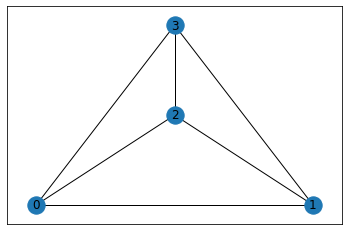

In [71]:
k4 = nx.complete_graph(4)
nx.draw_networkx(k4, pos=nx.planar_layout(k4))

Y es evidente que $K_4$ no se puede pintar con solo 3 colores. Ok... ¿entonces será cierto que todo grafo planar que no contenga a $K_4$ como subgrafo inducido es 3-coloreable?

Bueno, esta pregunta es un poco más difícil. Intentemos aplicar lo que aprendimos hasta ahora para buscar un contraejemplo.

Empecemos definiendo (mejor dicho, recordando) la función que construye un modelo en Python para el problema de Coloreo de Grafos, mediante la formulación de PLE que usa variables de asignación vértice-color $x_{vk}$ y de activación de colores $w_k$.

In [72]:
def max_grado(G):
    grados = [G.degree(v) for v in G]
    return max(grados)

def construir_modelo_col(G):
    """Construye un modelo de PLE para el PCV."""
    C = range(0,max_grado(G) + 1)
    modelo = Model(name='col')
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    modelo.minimize(modelo.sum(W[k] for k in C))
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= W[k])    
    return modelo

Ahora necesitamos una función que determine si un grafo tiene un $K_4$ como subgrafo inducido. Seguramente haya formas mas eficientes de implementarla. Nosotros iteraremos sobre cada vértice $u$ del grafo y sobre todas las ternas de tres vecinos de $u$. Procuraremos seguir un orden lexicográfico para evitar contabilizar varias veces un mismo subgrafo.

In [73]:
def tiene_k4(G):
    for u in G:
        for v in G.neighbors(u):
            if (v <= u):
                continue
            for w in G.neighbors(u):
                if (w <= v or not G.has_edge(w,v)):
                    continue
                for x in G.neighbors(u):
                    if (x <= w or not G.has_edge(x,w) or not G.has_edge(x,v)):
                        continue
                    return True
    return False

In [76]:
assert tiene_k4(nx.complete_graph(4))
assert tiene_k4(nx.complete_graph(5))
assert tiene_k4(nx.complete_graph(6))
assert not tiene_k4(nx.petersen_graph())

¡Listo! Ya estamos en condiciones de escribir nuestra conjetura como un predicado.

In [78]:
def conjetura_coloreo(G):
    if (not nx.is_planar(G) or tiene_k4(G)):
        return True
    modelo = construir_modelo_col(G)
    sol = modelo.solve()
    return modelo.objective_value <= 3

Ahora necesitamos llamar a <code>buscar_contraejemplo</code>, función definida en la Actividad 2. **Tendrá que resolver dicha actividad antes de poder ejecutar la siguiente celda.**

Procesando dataset: graph2c.g6
Procesando dataset: graph3c.g6
Procesando dataset: graph4c.g6
Procesando dataset: graph5c.g6
Procesando dataset: graph6c.g6


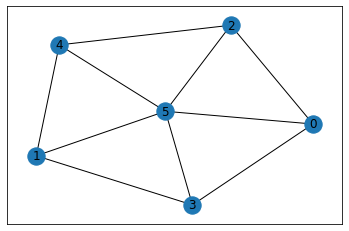

In [79]:
datasets = [f"graph{n}c.g6" for n in [2,3,4,5,6,7,8,9,10]]
contraej = buscar_contraejemplo(dirName, datasets, conjetura_coloreo)
nx.draw_networkx(contraej)

Bueno... recapítulemos un poco. Acabamos de encontramos un grafo planar sin $K_4$ inducido que no es 3-coloreable. Notar que este grafo es isomorfo al grafo rueda de 6 vértices (formado por un ciclo de 5 vértices y un vértice universal). Este contraejemplo nos lleva a pensar que tenemos que ser aún más restritivos, por ejemplo prohibiendo a $K_3$ como subgrafo inducido.

**Definición.** Un grafo es triangle-free si no tiene a $K_3$ como subgrafo inducido. 

**Observación.** Un grafo $G$ es triangle-free si y solo si $\omega(G) \leq 2$, donde $\omega(G)$ es el número de clique es $G$, es decir, el cardinal de la máxima clique de $G$.

Siguiendo con nuestra búsqueda, sería interesante saber si todo grafo planar y triangle-free es 3-coloreable. 

### &#x1f4bb; Actividad 3

* Usar lo aprendido en este notebook para buscar exhaustivamente un grafo planar y triangle-free con a lo sumo 10 vértices que no sea 3-coloreable.

* Una vez completado el primer punto, leer el abstract del siguiente <a href="https://doi.org/10.1016/S0095-8956(03)00029-7">paper</a>.

In [80]:
# Espacio para completar actividad 3

**Resolver Actividad 3 antes de continuar**

*PÁGINA INTENCIONALMENTE VACÍA*

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

&#11015;&#65039;

*PÁGINA INTENCIONALMENTE VACÍA*

Ok, ya sabemos que todo grafo planar y triangle-free es 3 coloreable, lo que mejora la cota que prevee el teorema de los 4 colores para esta clase de grafos. También ya sabemos que si sacamos la hipótesis de que el grafo sea triangle-free, entonces aparecen grafos planares que no son 3-coloreables (por ej. $K_4$ o grafo rueda de 6 vértices). Pero, ¿qué podemos decir acerca de la hipótesis de que el grafo sea planar? Es decir, ¿existirán grafos triangle-free que no sean 3-coloreables?

Esta última pregunta no es tan difícil de responder, pero necesitamos repasar un poco de teoría de grafos. Es sabido que a partir de un grafo $G$ triangle-free, es posible construir su grafo de Mycielski asociado $M(G)$, el cual preserva la propiedad de ser 3-triangle pero aumenta el número cromático. Por lo tanto, partiendo de un grafo triangle-free $G$ con $\chi(G)=3$, sabemos que $M(G)$ es triangle-free y $\chi(M(G))>3$. Puede investigar cómo es la construcción de Mycielski, aunque no es necesario para resolver la siguiente actividad.

### &#x1f4bb; Actividad 4

* Pensar en un grafo $G$ triangle-free con $\chi(G)=3$. No se complique demasiado, pensar en las clases de grafos más simples que se estudian en discreta.

* Llamar a la función <code>mycielskian</code> de <code>Networkx</code> para construir el grafo $M(G)$ asociado al grafo $G$ anterior.

* Verificar computacionalmente que $M(G)$ es triangle-free (o que $\omega(M(G)) \leq 2$) y que $\chi(M(G)) > 3$.

* Usar lo aprendido en el notebook para intentar encontrar mediante una búsqueda exhaustiva el grafo triangle-free con menor número de vértices que no sea 3-coloreable. ¿Lo puede encontrar? De lo contrario, investigue en la web cuál es este grafo. ¿Qué puede concluir?

In [ ]:
# Espacio para completar actividad 4

## 4. Abordaje de conjeturas abiertas

Conjetura abierta del coloreo aditivio. Daniel?

Concluir que podemos probar su validez hasta grafos de tantos vértices.